In [1]:
import numpy as np
import pandas as pd 
import re 
import gensim 
import json
import timeit
import networkx as nx
import matplotlib.pyplot as plt
import os
import sys
import pyLDAvis
import pyLDAvis.gensim

from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

print('Python Version: %s' % (sys.version))
%matplotlib inline

In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

Python Version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


In [4]:
brev = pd.read_csv("../data/gp-q2-clean.csv")
brev

,code,title,pub_date,citations,abstract,class,year
0,US8370262B2,System and method for performing secure online...,2013-02-05,"['US10681025B2', 'CN106664208B', 'AU2012261635...",\nThe system and method performing secure onli...,G06,2013
1,US10237070B2,System and method for sharing keys across auth...,2019-03-19,"['US10268809B2', 'JP6538821B2', 'KR101721032B1...","\nA system, apparatus, method, and machine rea...",H04,2019
2,US10637853B2,Authentication techniques including speech and...,2020-04-28,"['US10706421B2', 'US20160269411A1', 'US1021258...","\nA system, apparatus, method, and machine rea...",H04,2020
3,US10558974B2,Methods and systems of providing verification ...,2020-02-11,"['US20190149537A1', 'US20180308098A1', 'US2018...",\nA method and system of providing verificatio...,G06,2020
4,US10769635B2,Authentication techniques including speech and...,2020-09-08,"['US9531710B2', 'US10706421B2', 'US20160269411...","\nA system, apparatus, method, and machine rea...",G06,2020
...,...,...,...,...,...,...,...
9471,KR100477956B1,System and method for filtering message edited...,2005-03-23,"['US9501746B2', 'US10110519B2', 'US7133898B1',...",\r\nA method and system for filtering a messag...,H04,2005
9472,FR3092468A1,Secure registration and building control system,2020-08-07,"['US20150173255A1', 'US10147307B2', 'US9135807...",\r\n \r\n \r\n [Systme denregis...,H04,2020
9473,CN105723378B,Protection system including safety regulation ...,2019-06-18,"['JP2017034696A', 'CN107852410B', 'CN105210042...",\nThis disclosure relates to a kind of protect...,H04,2019
9474,EP2813983A1,Method and system for managing social interact...,2014-12-17,"['US10324776B2', 'EP2883359B1', 'US9536329B2',...",\r\nA method for managing social interactions ...,G06,2014


In [5]:
scop = pd.read_csv("../data/scopus-q2-clean.csv")

## TEXT PREPROCESSING

In [6]:
# Load the regular expression library
import re# Remove punctuation
brev['abstract_processed'] = brev['abstract'].map(lambda x: re.sub('[,\.!?]', '', x))# Convert the titles to lowercase
brev['abstract_processed'] = brev['abstract_processed'].map(lambda x: x.lower())# Print out the first rows of papers
brev['abstract'].head()

<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-6-b8811669afc8>:3: DeprecationWarning: invalid escape sequence \.
  brev['abstract_processed'] = brev['abstract'].map(lambda x: re.sub('[,\.!?]', '', x))# Convert the titles to lowercase


0    \nThe system and method performing secure onli...
1    \nA system, apparatus, method, and machine rea...
2    \nA system, apparatus, method, and machine rea...
3    \nA method and system of providing verificatio...
4    \nA system, apparatus, method, and machine rea...
Name: abstract, dtype: object

In [7]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = brev.abstract_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['the', 'system', 'and', 'method', 'performing', 'secure', 'online', 'transactions', 'based', 'on', 'challenge', 'response', 'procedures', 'executed', 'by', 'terminal', 'of', 'at', 'least', 'one', 'customer', 'and', 'by', 'terminal', 'of', 'service', 'provider', 'such', 'as', 'bank']


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

C:\Users\carlo\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\carlo\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [10]:
import spacy# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
data_lemmatized = data_words_bigrams #in realtà è senza lemmatiazion perchè ci dà problemi

In [11]:
import gensim.corpora as corpora# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)# Create Corpus
texts = data_lemmatized# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 7), (9, 2), (10, 4), (11, 1), (12, 1), (13, 1), (14, 1), (15, 6), (16, 8), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 2), (35, 2), (36, 1), (37, 1), (38, 2), (39, 1), (40, 4), (41, 1), (42, 1), (43, 6), (44, 1), (45, 1), (46, 1), (47, 1), (48, 4), (49, 1), (50, 1), (51, 1), (52, 6), (53, 1), (54, 1), (55, 4), (56, 1), (57, 1)]]


# Optimal number of topics ? 

In [26]:
def compute_performance(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence and perplexity for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity_values : Perplexity values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                num_topics=num_topics, 
                                                id2word=dictionary,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [27]:
model_list, coherence_values, perplexity_values = compute_performance(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, #dovremmo lemmatizzare
                                                        start=2, limit=20, step=1)

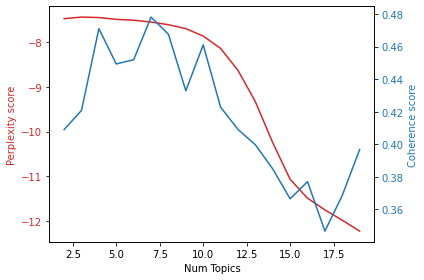

In [28]:


# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color)  # we already handled the x-label with ax1
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



# Use 4 topics

In [32]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=4, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [33]:
from pprint import pprint# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"device" + 0.019*"communication" + 0.018*"server" + '
  '0.018*"information" + 0.018*"user" + 0.016*"mobile" + 0.016*"message" + '
  '0.016*"authentication" + 0.012*"terminal" + 0.011*"service"'),
 (1,
  '0.023*"user" + 0.021*"one" + 0.020*"data" + 0.019*"first" + 0.016*"method" '
  '+ 0.015*"based" + 0.014*"may" + 0.014*"device" + 0.014*"computer" + '
  '0.013*"least"'),
 (2,
  '0.034*"data" + 0.033*"network" + 0.024*"system" + 0.018*"security" + '
  '0.012*"one" + 0.010*"based" + 0.008*"may" + 0.007*"traffic" + '
  '0.007*"information" + 0.006*"device"'),
 (3,
  '0.017*"method" + 0.017*"information" + 0.016*"data" + 0.015*"invention" + '
  '0.011*"detection" + 0.011*"model" + 0.009*"according" + 0.009*"system" + '
  '0.008*"unit" + 0.008*"module"')]


In [34]:
from gensim.models import CoherenceModel# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.44171001013762784


# 7 topics

In [12]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=7, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [13]:
from pprint import pprint# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"model" + 0.024*"malicious" + 0.021*"detection" + 0.018*"behavior" + '
  '0.018*"based" + 0.016*"learning" + 0.015*"feature" + 0.015*"network" + '
  '0.014*"set" + 0.014*"attack"'),
 (1,
  '0.077*"user" + 0.043*"content" + 0.012*"mobile" + 0.012*"based" + '
  '0.012*"information" + 0.011*"display" + 0.010*"media" + 0.010*"search" + '
  '0.010*"input" + 0.010*"users"'),
 (2,
  '0.085*"data" + 0.034*"one" + 0.023*"network" + 0.020*"system" + '
  '0.016*"least" + 0.015*"plurality" + 0.015*"event" + 0.013*"based" + '
  '0.012*"traffic" + 0.009*"node"'),
 (3,
  '0.023*"information" + 0.022*"invention" + 0.020*"data" + 0.017*"method" + '
  '0.014*"system" + 0.013*"module" + 0.013*"unit" + 0.012*"according" + '
  '0.011*"image" + 0.010*"present"'),
 (4,
  '0.030*"computer" + 0.027*"file" + 0.026*"application" + 0.023*"computing" + '
  '0.022*"may" + 0.020*"device" + 0.020*"method" + 0.016*"data" + '
  '0.015*"disclosed" + 0.015*"include"'),
 (5,
  '0.032*"device" + 0.025*"securi

In [14]:
from gensim.models import CoherenceModel# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48503046908917974


In [15]:
lda_model.print_topics()

[(0,
  '0.026*"model" + 0.024*"malicious" + 0.021*"detection" + 0.018*"behavior" + 0.018*"based" + 0.016*"learning" + 0.015*"feature" + 0.015*"network" + 0.014*"set" + 0.014*"attack"'),
 (1,
  '0.077*"user" + 0.043*"content" + 0.012*"mobile" + 0.012*"based" + 0.012*"information" + 0.011*"display" + 0.010*"media" + 0.010*"search" + 0.010*"input" + 0.010*"users"'),
 (2,
  '0.085*"data" + 0.034*"one" + 0.023*"network" + 0.020*"system" + 0.016*"least" + 0.015*"plurality" + 0.015*"event" + 0.013*"based" + 0.012*"traffic" + 0.009*"node"'),
 (3,
  '0.023*"information" + 0.022*"invention" + 0.020*"data" + 0.017*"method" + 0.014*"system" + 0.013*"module" + 0.013*"unit" + 0.012*"according" + 0.011*"image" + 0.010*"present"'),
 (4,
  '0.030*"computer" + 0.027*"file" + 0.026*"application" + 0.023*"computing" + 0.022*"may" + 0.020*"device" + 0.020*"method" + 0.016*"data" + 0.015*"disclosed" + 0.015*"include"'),
 (5,
  '0.032*"device" + 0.025*"security" + 0.024*"network" + 0.022*"information" + 0.02

In [16]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

from spacy.lang.en import English

C:\Users\carlo\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [17]:
pyLDAvis.display(LDAvis_prepared)

### Assign patents to topics

In [22]:
brev['topic'] = [scores[np.argmax([score[1] for score in scores])][0] for scores in lda_model.get_document_topics(corpus)]
brev.topic.value_counts()

5    2292
3    1763
4    1674
0    1221
6     909
1     828
2     789
Name: topic, dtype: int64

In [29]:
brev.to_csv('../data/gp-q2-7topics.csv')

### Assign scopus papers to topics

In [27]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

texts = [[w for w in text.split(' ') if w not in stopwords] for text in scop.abstract] #tokenization


corpus = [id2word.doc2bow(text) for text in texts]

In [28]:
scop['topic'] = [scores[np.argmax([score[1] for score in scores])][0] for scores in lda_model.get_document_topics(corpus)]
scop.topic.value_counts()

0    3189
3    2182
5    2169
1     248
2      84
6      75
4      34
Name: topic, dtype: int64

In [42]:
scop.to_csv('../data/scopus-q2-7topics.csv')